# Bayesian Networks

In this notebook, I explain what a Bayesian network is and how it works, and I do a medical informatics case study to demonstrate the material I cover.

*Data for this notebook is from the CDC's [COVID-19 Case Surveillance Public Use Data with Geography](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/n8mc-b4w4/data) dataset, filtered to remove rows with missing or unknown values.*

In [1]:
%cd ..
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from network import CategoricalBayesianNetwork
from pathlib import Path

/Users/ivan/src/bayesian_network_test
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



## What is a Bayesian network?

A **Bayesian network** is a statistical method for representing causal relationships between variables. Here is a simple example:

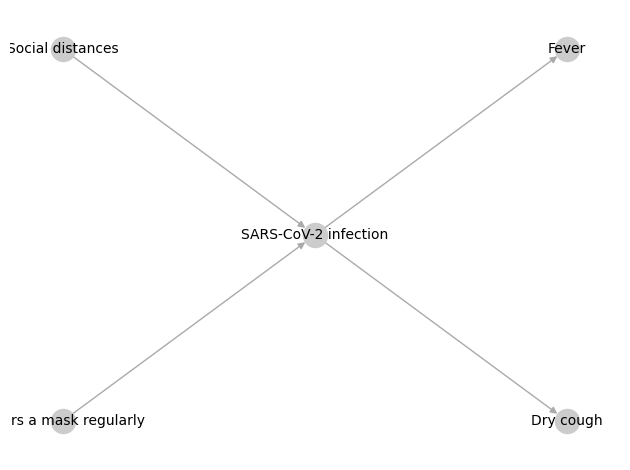

In [2]:
network = CategoricalBayesianNetwork()
network.add_variables('Wears a mask regularly', 'Social distances', 'SARS-CoV-2 infection', 'Fever', 'Dry cough')
network.add_dependencies_to('SARS-CoV-2 infection', ['Wears a mask regularly', 'Social distances'])
network.add_dependency_to('Fever', 'SARS-CoV-2 infection')
network.add_dependency_to('Dry cough', 'SARS-CoV-2 infection')
fig, ax = plt.subplots()
network.draw(ax=ax, font_size=10, node_color='#cccccc', edge_color='#aaaaaa')
fig.tight_layout()

In this network, there are five variables: whether the person wears a mask, whether they social distance, and whether they've been infected with SARS-CoV-2, whether they have a fever, and whether they have a dry cough.

The arrows in the network represent causal relationships between variables. For example, we'd expect that wearing a mask has an impact on SARS-CoV-2 infection probability, so there is an arrow from "Wears a mask regularly" to "SARS-CoV-2" infection. A SARS-CoV-2 infection may cause the symptoms on the right, so there is an arrow to those.

A Bayesian network's structure is represented by something called a **directed acyclic graph** (DAG). "Graph" means that this is a structure with relationships between nodes represented by edges, "directed" means those directions go in one way, and "acyclic" means that, if one were to travel from node to node using only the directed edges, it is impossible to return to where you started. Practically, this last restriction means that you can't have variables that depend on each other.

From a mathematical view, Bayesian networks are a way of representing a joint probability distribution using the "chain rule" of probability ($\mathrm{Pr}\left(X,Y\right) = \mathrm{Pr}\left(X \mid Y\right)\mathrm{Pr}\left(Y\right)$). For example, for the Bayesian network above, the connection from "SARS-CoV-2 infection" to "Fever" is a factor of the joint probability distribution of all the variables in the network, and that factor is
$\mathrm{Pr}\left(F \mid I\right) \mathrm{Pr}\left(F\right)$.
There is no connection between "Fever" and "Dry cough" in the network, so the factor for those two is
$\mathrm{Pr}\left(F\right) \mathrm{Pr}\left(C\right)$ ($\mathrm{Pr}\left(F \mid C\right) = \mathrm{Pr}\left(F\right)$ because the variables are independent).
These two factors overlap via the $\mathrm{Pr}\left(F\right)$ term. Finally, the "Social distances" variable is not dependent on any other, so its factor is simply
$\mathrm{Pr}\left(S\right)$.

## Probability queries

The main use of a (trained) Bayesian network is to perform probability queries. These are split into two types: probabilistic queries and interventional queries.

### Probabilistic queries

A **probabilistic query** is a query for a probability distribution of a certain variable, possibly conditioned on one or more other probability distribution.

In [3]:
save_path = Path('data/covid_data.csv')

if save_path.exists():
    df = pd.read_csv(save_path)
else:
    raise FileNotFoundError('Data is missing.')

df.drop(columns=['case_month', 'state_fips_code', 'res_county', 'county_fips_code', 'case_positive_specimen_interval', 'process', 'current_status', 'case_onset_interval', 'exposure_yn', 'symptom_status'], inplace=True)
df = df.apply(lambda col: col.astype('category'), axis=0)
df

,res_state,age_group,sex,race,ethnicity,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,OH,18 to 49 years,Female,White,Hispanic/Latino,No,No,No,No
1,OH,18 to 49 years,Female,White,Hispanic/Latino,No,No,No,No
2,OH,18 to 49 years,Female,White,Hispanic/Latino,No,No,No,No
3,OH,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,No
4,OH,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,No
...,...,...,...,...,...,...,...,...,...
586469,MO,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
586470,TX,65+ years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
586471,TX,18 to 49 years,Male,White,Hispanic/Latino,No,No,No,Yes
586472,TX,18 to 49 years,Male,White,Non-Hispanic/Latino,No,No,No,Yes


In [4]:
{name: df[name].cat.categories.to_list() for name in df.columns}

{'res_state': ['AK',
  'AL',
  'AR',
  'CA',
  'CO',
  'DC',
  'FL',
  'GA',
  'GU',
  'IA',
  'ID',
  'IL',
  'IN',
  'KS',
  'KY',
  'LA',
  'MD',
  'ME',
  'MI',
  'MN',
  'MO',
  'MS',
  'MT',
  'NC',
  'NE',
  'NH',
  'NJ',
  'NV',
  'NY',
  'OH',
  'OR',
  'PA',
  'PR',
  'TN',
  'TX',
  'UT',
  'VA',
  'VI',
  'VT',
  'WA',
  'WI',
  'WY'],
 'age_group': ['0 - 17 years',
  '18 to 49 years',
  '50 to 64 years',
  '65+ years'],
 'sex': ['Female', 'Male'],
 'race': ['American Indian/Alaska Native',
  'Asian',
  'Black',
  'Multiple/Other',
  'Native Hawaiian/Other Pacific Islander',
  'White'],
 'ethnicity': ['Hispanic/Latino', 'Non-Hispanic/Latino'],
 'hosp_yn': ['No', 'Yes'],
 'icu_yn': ['No', 'Yes'],
 'death_yn': ['No', 'Yes'],
 'underlying_conditions_yn': ['No', 'Yes']}

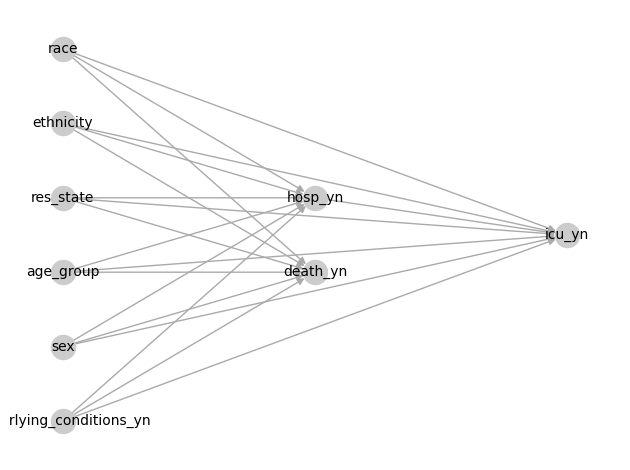

In [5]:
network = CategoricalBayesianNetwork()
network.add_variables_from_data(df)
network.add_dependencies_to('hosp_yn', ['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn'])
network.add_dependencies_to('icu_yn', ['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn', 'hosp_yn'])
network.add_dependencies_to('death_yn', ['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn'])
fig, ax = plt.subplots()
network.draw(ax=ax, font_size=10, node_color='#cccccc', edge_color='#aaaaaa')
fig.tight_layout()

In [6]:
network.fit(df)
network.bayes_net

BayesianNetwork(
  (distributions): ModuleList(
    (0-4): 5 x Categorical()
    (5): ConditionalCategorical(
      (probs): ParameterList(  (0): Parameter containing: [torch.float32 of size 42x4x2x6x2x2x2])
      (_w_sum): [tensor([[[[[[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]]],
      
      
                [[[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]],
      
                 [[0., 0.],
                  [0., 0.]]]],
      
   

In [7]:
analyzer = network.analyze()

/opt/anaconda3/envs/music/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [8]:
print('General:')
print(analyzer.get_probability_for('hosp_yn'))
for race in network.get_categories_for('race'):
    print(f'{race}:')
    with analyzer.freezing(race=race):
        print(analyzer.get_probability_for('hosp_yn'))

General:
No     0.758626
Yes    0.241374
Name: hosp_yn, dtype: float32
American Indian/Alaska Native:
No     0.574356
Yes    0.425644
Name: hosp_yn, dtype: float32
Asian:
No     0.730105
Yes    0.269895
Name: hosp_yn, dtype: float32
Black:
No     0.695715
Yes    0.304285
Name: hosp_yn, dtype: float32
Multiple/Other:
No     0.733102
Yes    0.266898
Name: hosp_yn, dtype: float32
Native Hawaiian/Other Pacific Islander:
No     0.534282
Yes    0.465718
Name: hosp_yn, dtype: float32
White:
No     0.769418
Yes    0.230582
Name: hosp_yn, dtype: float32


In [9]:
print('General:')
print(analyzer.get_probability_for('death_yn'))
for race in network.get_categories_for('race'):
    print(f'{race}:')
    with analyzer.freezing(race=race):
        print(analyzer.get_probability_for('death_yn'))

General:
No     0.939953
Yes    0.060047
Name: death_yn, dtype: float32
American Indian/Alaska Native:
No     0.623099
Yes    0.376901
Name: death_yn, dtype: float32
Asian:
No     0.907442
Yes    0.092558
Name: death_yn, dtype: float32
Black:
No     0.903633
Yes    0.096367
Name: death_yn, dtype: float32
Multiple/Other:
No     0.901377
Yes    0.098623
Name: death_yn, dtype: float32
Native Hawaiian/Other Pacific Islander:
No     0.554715
Yes    0.445285
Name: death_yn, dtype: float32
White:
No     0.947327
Yes    0.052673
Name: death_yn, dtype: float32


## Sources I used

* [Bayesian network (wikipedia.com)](https://en.wikipedia.org/wiki/Bayesian_network)
* [What is a Bayesian network? (Norman Fenton, youtube.com)](https://www.youtube.com/watch?v=97KBdmSQEJ0)
* [Introduction to Bayesian Belief Networks (Jason Brownlee, machinelearningmastery.com)](https://machinelearningmastery.com/introduction-to-bayesian-belief-networks/)
* [@easylearning246 (youtube.com)](https://www.youtube.com/@easylearning246) (a channel with a complete course on Bayesian networks; only some sections of some chapters were used)
* [Bayesian Networks (Jacob Schreiber, pomegranate.readthedocs.io)](https://pomegranate.readthedocs.io/en/latest/tutorials/B_Model_Tutorial_6_Bayesian_Networks.html)